# Friedman example with different values of $\alpha$ and $m$

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import pymc_bart as pmb
from pymc_bart.pgbart import compute_prior_probability

In [2]:
RANDOM_SEED = 4579
np.random.seed(RANDOM_SEED)
az.style.use("arviz-white")
plt.rcParams["figure.dpi"] = 300

## Data generation

In [3]:
X = np.random.uniform(low=0, high=1.0, size=(100, 10))
f_x = (
    10 * np.sin(np.pi * X[:, 0] * X[:, 1])
    + 20 * (X[:, 2] - 0.5) ** 2
    + 10 * X[:, 3]
    + 5 * X[:, 4]
)
Y = np.random.normal(f_x, 1)

In [4]:
trees = [10, 20, 50, 100, 200]
alphas = [0.1, 0.25, 0.5]
idatas_at = {
    "10": {"0.1": {}, "0.25": {}, "0.5": {}},
    "20": {"0.1": {}, "0.25": {}, "0.5": {}},
    "50": {"0.1": {}, "0.25": {}, "0.5": {}},
    "100": {"0.1": {}, "0.25": {}, "0.5": {}},
    "200": {"0.1": {}, "0.25": {}, "0.5": {}},
}
m_trees = {
    "10": {"0.1": {}, "0.25": {}, "0.5": {}},
    "20": {"0.1": {}, "0.25": {}, "0.5": {}},
    "50": {"0.1": {}, "0.25": {}, "0.5": {}},
    "100": {"0.1": {}, "0.25": {}, "0.5": {}},
    "200": {"0.1": {}, "0.25": {}, "0.5": {}},
}

In [5]:
for m in trees:
    for alpha in alphas:
        with pm.Model() as model:
            μ = pmb.BART("μ", X, Y, m=m, alpha=alpha)
            σ = pm.HalfNormal("σ", 1)
            y = pm.Normal("y", μ, σ, observed=Y)
            idata = pm.sample(chains=4, random_seed=RANDOM_SEED)
            idatas_at[str(m)][str(alpha)] = idata
            m_trees[str(m)][str(alpha)] = μ.owner.op.all_trees

Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 20 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 25 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 37 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 35 seconds.
The acceptance probability does not match the target. It is 0.8803, but should be close to 0.8. Try to increase the number of tuning steps.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 44 seconds.
The acceptance probability does not match the target. It is 0.8921, but should be close to 0.8. Try to increase the number of tuning steps.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 67 seconds.
The acceptance probability does not match the target. It is 0.6908, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.7003, but should be close to 0.8. Try to increase the number of tuning steps.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 78 seconds.
The acceptance probability does not match the target. It is 0.8967, but should be close to 0.8. Try to increase the number of tuning steps.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 98 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 151 seconds.
The acceptance probability does not match the target. It is 0.8983, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8929, but should be close to 0.8. Try to increase the number of tuning steps.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 146 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 187 seconds.
The acceptance probability does not match the target. It is 0.8814, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8883, but should be close to 0.8. Try to increase the number of tuning steps.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 295 seconds.
The acceptance probability does not match the target. It is 0.7001, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.903, but should be close to 0.8. Try to increase the number of tuning steps.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 278 seconds.
The acceptance probability does not match the target. It is 0.8822, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8838, but should be close to 0.8. Try to increase the number of tuning steps.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 355 seconds.
The acceptance probability does not match the target. It is 0.8787, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8804, but should be close to 0.8. Try to increase the number of tuning steps.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 592 seconds.
The acceptance probability does not match the target. It is 0.904, but should be close to 0.8. Try to increase the number of tuning steps.


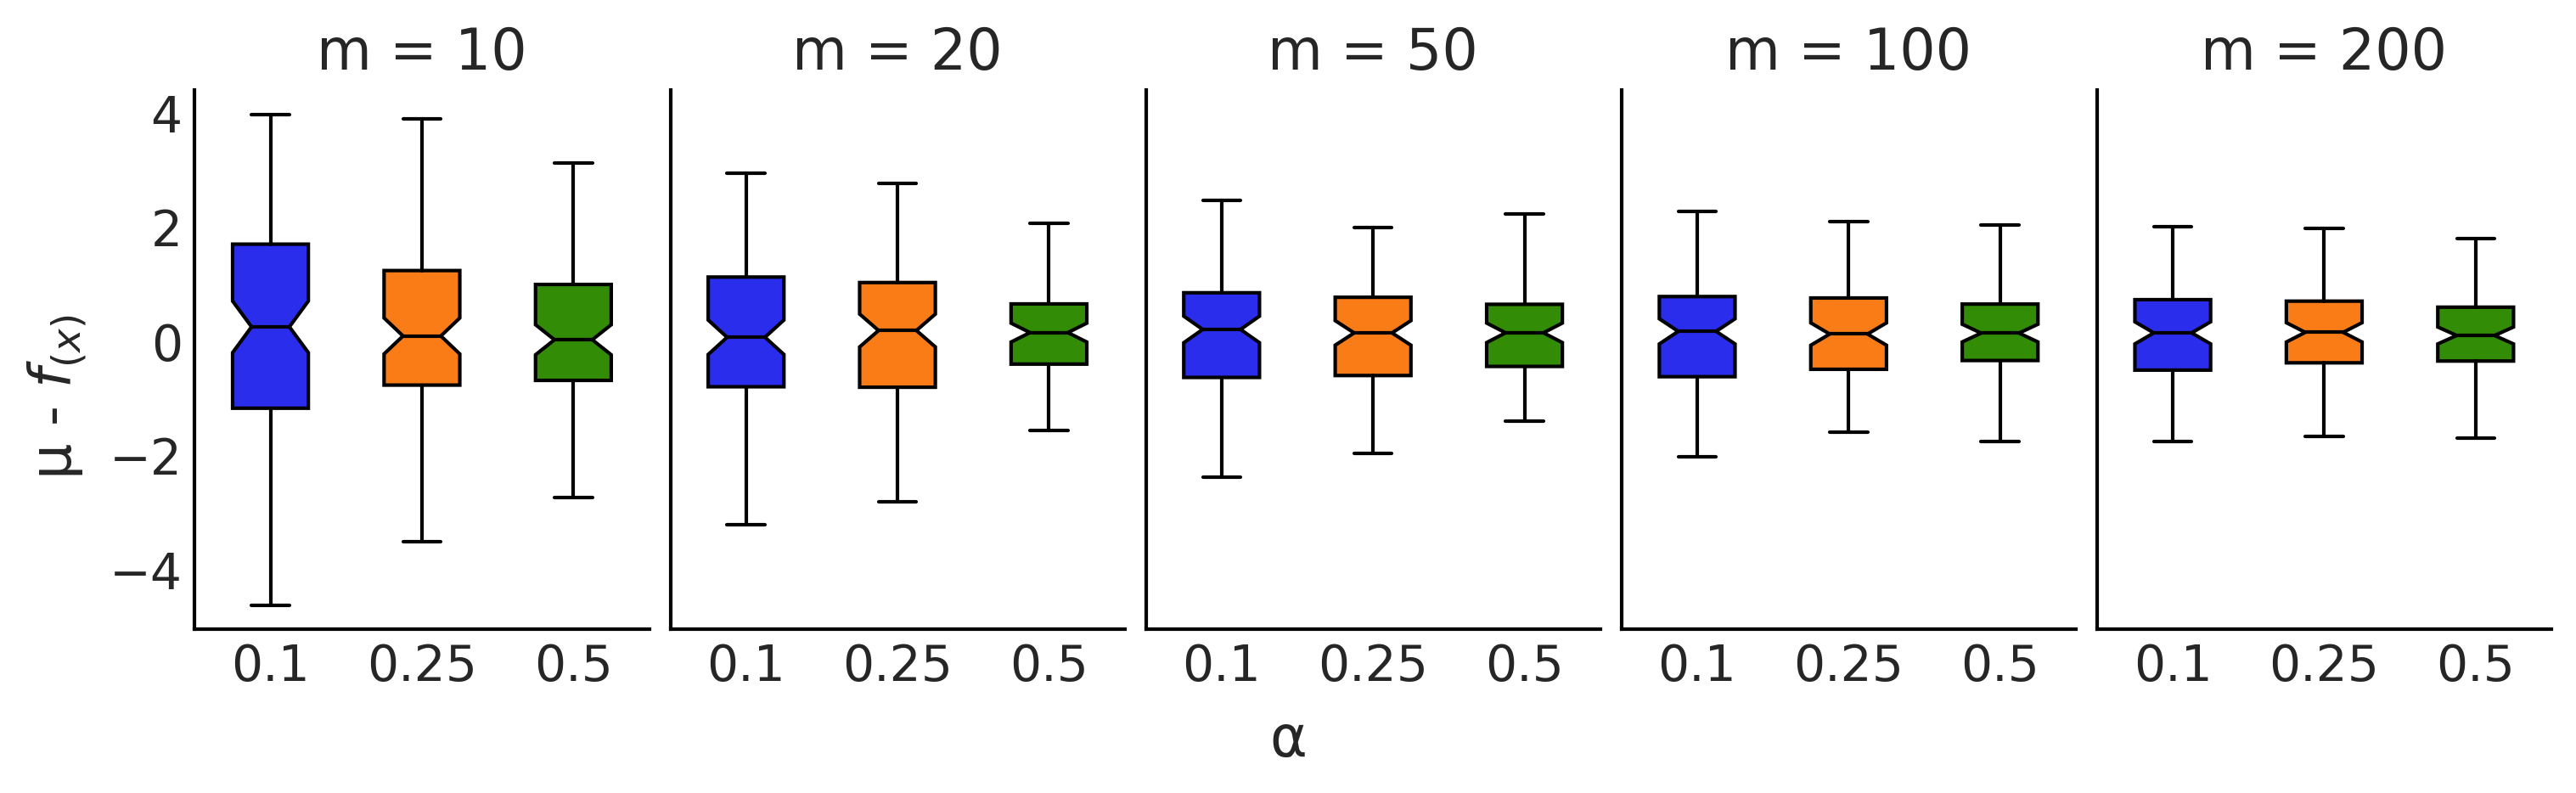

In [6]:
fig, axes = plt.subplots(1, 5, figsize=(10, 3), sharey=True)

axes = axes.ravel()

for m, ax in zip(trees, axes):
    means = [
        idatas_at[str(m)][str(alpha)]["posterior"]["μ"].mean(("chain", "draw")) - f_x
        for alpha in alphas
    ]
    box = ax.boxplot(
        means,
        notch=True,
        patch_artist=True,
        widths=0.5,
        labels=alphas,
        showfliers=False,
        medianprops=dict(color="k"),
    )
    for patch, color in zip(box["boxes"], ["C0", "C1", "C2", "C3"]):
        patch.set_facecolor(color)
        ax.set_title(f"m = {m}")

fig.supxlabel(r"α", fontsize=16)
fig.supylabel(r"μ - $f_{(x)}$", fontsize=16)

plt.savefig("boxplots_friedman_i2.png")

## PSIS-LOO-CV

In [7]:
model_compare = az.compare(
    {
        "m10": idatas_at["10"]["0.25"],
        "m20": idatas_at["20"]["0.25"],
        "m50": idatas_at["50"]["0.25"],
        "m100": idatas_at["100"]["0.25"],
        "m200": idatas_at["200"]["0.25"],
    }
)

/home/pablo/anaconda3/envs/bart-experiments/lib/python3.9/site-packages/arviz/stats/stats.py:802: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/home/pablo/anaconda3/envs/bart-experiments/lib/python3.9/site-packages/arviz/stats/stats.py:1036: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)
/home/pablo/anaconda3/envs/bart-experiments/lib/python3.9/site-packages/arviz/stats/stats.py:802: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely

In [8]:
model_compare

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
m200,0,-163.355596,40.558408,0.000000,1.000000e+00,10.071096,0.000000,True,log
m100,1,-182.881887,41.385273,19.526291,2.706174e-11,10.979329,1.891401,True,log
m50,2,-196.278303,39.047419,32.922707,1.857786e-11,9.835351,2.234737,True,log
m20,3,-224.432498,39.765324,61.076902,5.638878e-12,8.793594,4.387072,True,log
m10,4,-240.684287,39.126149,77.328691,0.000000e+00,8.194836,5.512268,True,log


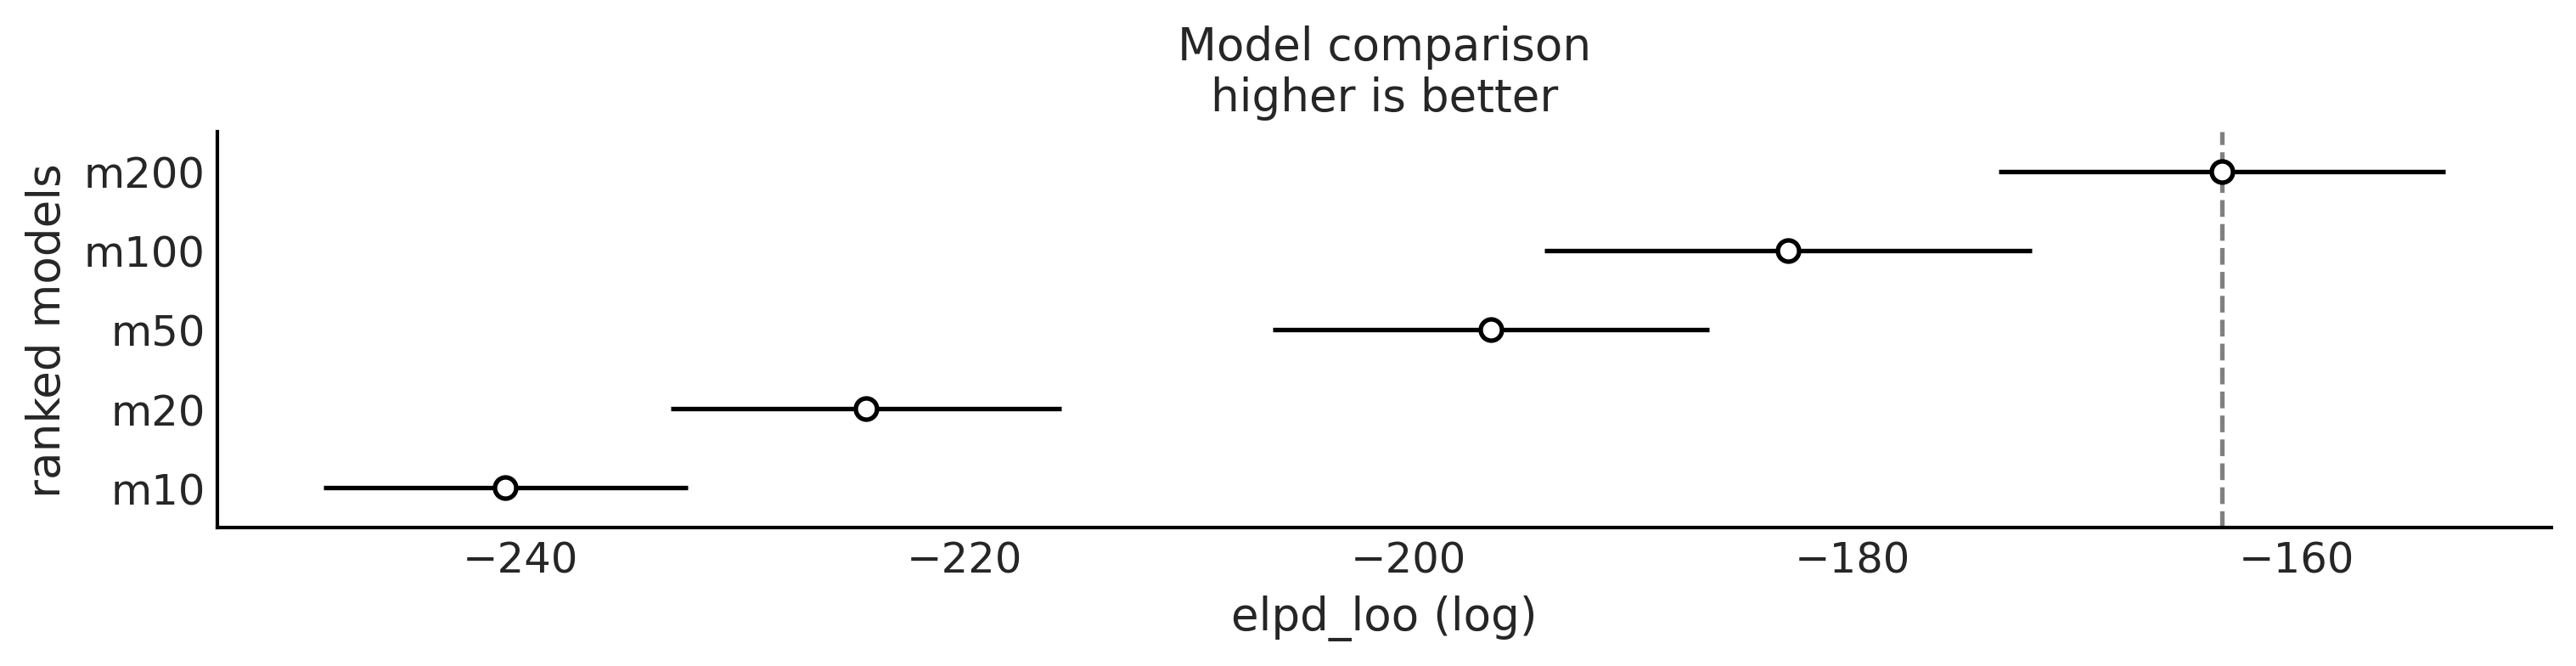

In [9]:
ax = az.plot_compare(
    model_compare,
    plot_ic_diff=False,
    insample_dev=False,
    figsize=(10, 2.5),
    legend=False,
)

plt.savefig("loo_friedman_i2.png")

## Tree extraction  

In [10]:
trees_length = {
    "10": {"0.1": {}, "0.25": {}, "0.5": {}},
    "20": {"0.1": {}, "0.25": {}, "0.5": {}},
    "50": {"0.1": {}, "0.25": {}, "0.5": {}},
    "100": {"0.1": {}, "0.25": {}, "0.5": {}},
    "200": {"0.1": {}, "0.25": {}, "0.5": {}},
}

In [11]:
for m in trees:
    for alpha in alphas:
        tmp_list = []
        chain = m_trees[str(m)][str(alpha)]
        for sample in chain:
            for tree in sample:
                index = max(tree.tree_structure.keys())
                tmp_list.append(pmb.tree.BaseNode(index).depth)
        trees_length[f"{m}"][f"{alpha}"] = pd.Series(tmp_list)

In [12]:
# Trees' depth probabilities based on alpha values
prob_alphas = []
for alpha in alphas:
    q = compute_prior_probability(alpha)
    p = 1 - np.array(q)
    p = p / p.sum()
    prob_alphas.append(p)

### Frequency of trees depths

In [13]:
colors = ["C0", "C1", "C2"]
wd = 0.33
wd_lst = [0, wd, wd * 2]

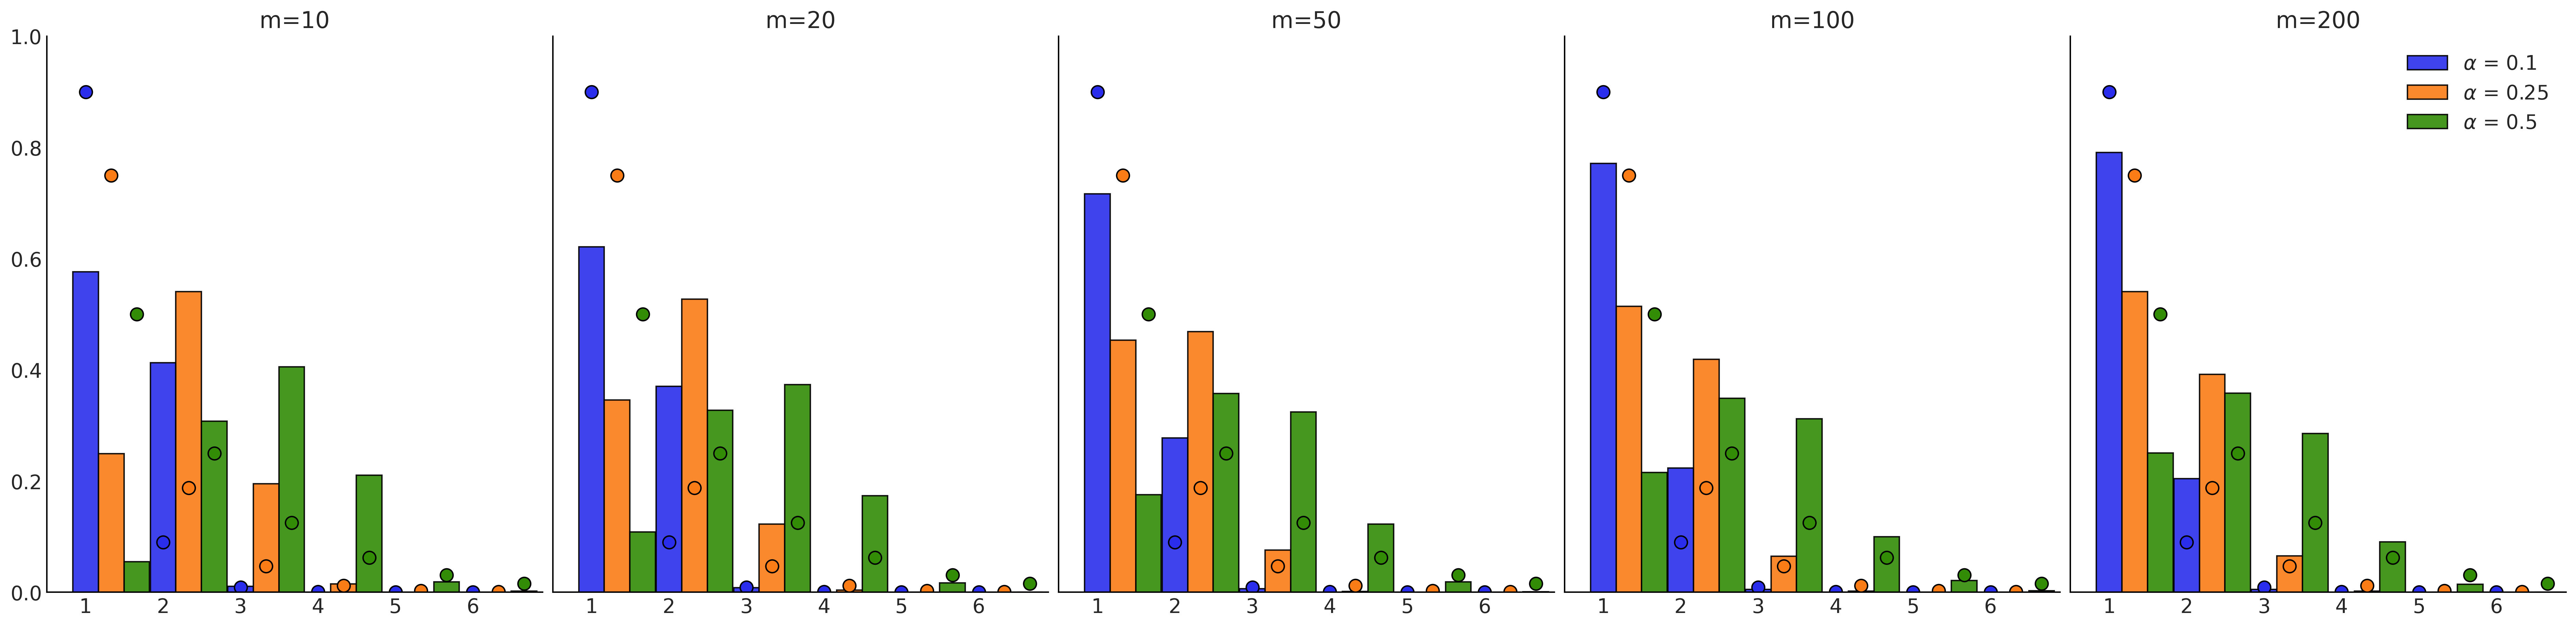

In [14]:
# All frequencies in one plot
fig, axes = plt.subplots(1, 5, figsize=(25, 6), sharey=True)

for m, ax in zip(trees, axes.ravel()):
    for i in range(0, len(alphas)):
        # Trees Depth Frequencies
        frequency = (
            trees_length[f"{m}"][f"{alphas[i]}"]
            .value_counts(normalize=True)
            .sort_index(ascending=True)
        )
        ax.bar(
            frequency.index + wd_lst[i],
            frequency.values,
            color=colors[i],
            width=wd,
            edgecolor="k",
            alpha=0.9,
            label=rf"$\alpha$ = {alphas[i]}",
        )
        # Probabilities
        x = np.array(range(1, len(prob_alphas[i]) + 1)) + wd_lst[i]
        ax.scatter(
            x,
            prob_alphas[i],
            facecolor=colors[i],
            edgecolor="k",
            marker="o",
            s=80,
            zorder=2,
        )

    major_ticks = np.arange(0, 7, 1)
    ax.set_xticks(major_ticks)
    ax.set_ylim(0, 1)
    ax.set_xlim(0.5, 6.9)
    ax.set_title(f"m={m}")
    if m == 200:
        ax.legend()

plt.savefig("friedman_i2_hist.png");